In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import nltk
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
import torch
import umap.umap_ as umap
import hdbscan


In [2]:
device = torch.device('mps')
print('Using device:', device)

Using device: mps


In [3]:
########## Question 1
cats = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']
newsgroups_all = fetch_20newsgroups(subset='all', categories = cats, shuffle=True, random_state=0, remove=('headers','footers'))
data = pd.DataFrame(newsgroups_all.data)

cuntVectorizer = CountVectorizer(stop_words='english', min_df=3)
tfidf = TfidfTransformer(use_idf=True)

wordCounts = tfidf.fit_transform(cuntVectorizer.fit_transform(newsgroups_all.data))
wordCounts = pd.DataFrame(data=wordCounts.toarray(), columns=cuntVectorizer.get_feature_names_out())
y_true = [0 if label < 4 else 1 for label in newsgroups_all.target]

print("There are "+str(wordCounts.shape[0])+" samples and "+str(wordCounts.shape[1])+" features.")

There are 7882 samples and 23522 features.


In [4]:
########## Question 2
kmeans = KMeans(init='k-means++', max_iter=1000, n_clusters=2, n_init=30, random_state=0)
kmeans.fit(wordCounts)


KMeans(max_iter=1000, n_clusters=2, n_init=30, random_state=0)

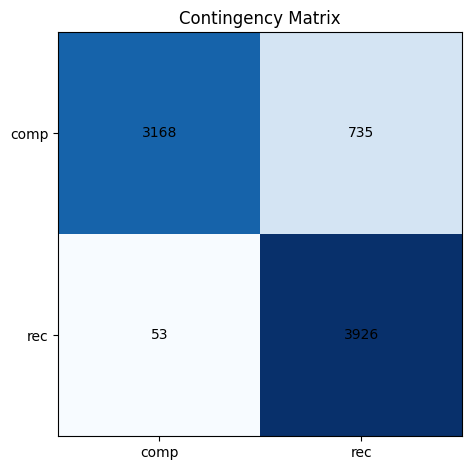

In [5]:
def plot_matrix(matrix, labels, title):
    # matrix: numpy array of shape (n_classes, n_classes)
    # labels: list of length n_classes containing class labels
    
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap='Blues')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, matrix[i, j],
                           ha="center", va="center", color="black")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()
y_pred = kmeans.labels_
contingencyMatrix = contingency_matrix(y_true,y_pred)
binaryLabels = ['comp', 'rec']

plot_matrix(contingencyMatrix, binaryLabels, "Contingency Matrix")


In [6]:

########## Question 3
def scoreVec(y_true, y_pred):
    scoreVec = []
    scoreVec.append(homogeneity_score(y_true, y_pred))
    scoreVec.append(completeness_score(y_true, y_pred))
    scoreVec.append(v_measure_score(y_true,y_pred))
    scoreVec.append(adjusted_rand_score(y_true,y_pred))
    scoreVec.append(adjusted_mutual_info_score(y_true,y_pred))
    from prettytable import PrettyTable
    table = PrettyTable()
    table.field_names = ["Metric", "Score"]
    table.add_row(["Homogeneity Score", scoreVec[0]])
    table.add_row(["Completeness Score", scoreVec[1]])
    table.add_row(["V-Measure Score", scoreVec[2]])
    table.add_row(["Adjusted Rand Score", scoreVec[3]])
    table.add_row(["Adjusted Mutual Info Score", scoreVec[4]])
    return scoreVec, table

kmeans_scores, kmeans_table = scoreVec(y_true=y_true, y_pred=y_pred)
print(kmeans_table)

+----------------------------+--------------------+
|           Metric           |       Score        |
+----------------------------+--------------------+
|     Homogeneity Score      | 0.5786933027101565 |
|     Completeness Score     | 0.5930127784164637 |
|      V-Measure Score       | 0.5857655410667186 |
|    Adjusted Rand Score     | 0.6400359369002737 |
| Adjusted Mutual Info Score | 0.5857271539449475 |
+----------------------------+--------------------+


In [ ]:
########## Question 11

In [7]:
########## Question 14
components = [5, 20, 200]
for r in components:
    print('r = ' + str(r))
    umap_20 = umap.UMAP(n_components=r, metric='cosine')
    wordCountUMAP = umap_20.fit_transform(wordCounts)
    aggWard = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(wordCountUMAP)
    aggSingle = AgglomerativeClustering(n_clusters=20, linkage='single').fit(wordCountUMAP)

    aggWard_scores, aggWard_table = scoreVec(newsgroups_all.target, aggWard.labels_)
    aggSingle_scores, aggSingle_table = scoreVec(newsgroups_all.target, aggSingle.labels_)

    print('scores of agglomerative clustering with ward:')
    print(aggWard_table)

    print('scores of agglomerative clustering with single:')
    print(aggSingle_table)
    

r = 5
scores of agglomerative clustering with ward:
+----------------------------+--------------------+
|           Metric           |       Score        |
+----------------------------+--------------------+
|     Homogeneity Score      | 0.6275206266822274 |
|     Completeness Score     | 0.4686141062767413 |
|      V-Measure Score       | 0.5365490369036966 |
|    Adjusted Rand Score     | 0.4389733606273227 |
| Adjusted Mutual Info Score | 0.5348994441963826 |
+----------------------------+--------------------+
scores of agglomerative clustering with single:
+----------------------------+---------------------+
|           Metric           |        Score        |
+----------------------------+---------------------+
|     Homogeneity Score      |  0.2243270277544013 |
|     Completeness Score     |  0.6534707388639146 |
|      V-Measure Score       | 0.33399754282481625 |
|    Adjusted Rand Score     |  0.1319823607674821 |
| Adjusted Mutual Info Score |  0.3297656532514218 |
+-------

In [22]:
########## Question 15
min_cluster = [20,100,200]
def get_max_index(mat):
    return np.unravel_index(np.argmax(mat, axis=None), mat.shape)

eps = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0, 25.0, 50.0]
min_samples = [5,10,30,60,75,100,200,500,1000]
bestHDBSCAN = 0
hs = np.zeros((len(eps), len(min_samples), len(min_cluster)))
cs = np.zeros((len(eps), len(min_samples), len(min_cluster)))
vms = np.zeros((len(eps), len(min_samples), len(min_cluster)))
aris = np.zeros((len(eps), len(min_samples), len(min_cluster)))
amis = np.zeros((len(eps), len(min_samples), len(min_cluster)))
avg_score = np.zeros((len(eps), len(min_samples), len(min_cluster)))

for i in range(len(eps)):
    for j in range(len(min_samples)):
        for k in range(len(min_cluster)):
            hdbs = hdbscan.HDBSCAN(min_cluster_size=min_cluster[k], cluster_selection_epsilon=eps[i], min_samples=min_samples[j]).fit_predict(wordCountUMAP)
            hdbs_scores, hdbs_table = scoreVec(newsgroups_all.target, hdbs)

            hs[i, j, k] = hdbs_scores[0]
            cs[i, j, k] = hdbs_scores[1]
            vms[i, j, k] = hdbs_scores[2]
            aris[i, j, k] = hdbs_scores[3]
            amis[i, j, k] = hdbs_scores[4]

            avg_score[i, j, k] = (hs[i, j, k] + cs[i, j, k] + vms[i, j, k] + aris[i, j, k] + amis[i, j, k]) / 5

            if(avg_score[i, j, k] > bestHDBSCAN):
                bestHDBSCAN = avg_score[i, j, k]
                bestEpsHDBSCAN = eps[i]
                bestMinSamplesHDBSCAN = min_samples[j]
                bestMinCluster = min_cluster[k]

print('Best eps for HDBSCAN: ' + str(bestEpsHDBSCAN))
print('Best Min Samples for HDBSCAN: ' + str(bestMinSamplesHDBSCAN))
print('Best Min Cluster for HDBSCAN: ' + str(bestMinCluster))
print('Best Score for HDBSCAN: ' + str(bestHDBSCAN))

print('Best in terms of Adjusted Rand Index score')
(i, j, k) = get_max_index(aris)
print('Best Score:' + str(aris.max()))
print('Best eps for DBSCAN: ' + str(eps[i]))
print('Best Min Samples for DBSCAN: ' + str(min_samples[j]))
print('Best Min Cluster for DBSCAN: ' + str(min_cluster[k]))

Best eps for HDBSCAN: 0.01
Best Min Samples for HDBSCAN: 30
Best Min Cluster for HDBSCAN: 200
Best Score for HDBSCAN: 0.43915293426192903
Best in terms of Adjusted Rand Index score
Best Score:0.3466967587612477
Best eps for DBSCAN: 0.01
Best Min Samples for DBSCAN: 30
Best Min Cluster for DBSCAN: 200


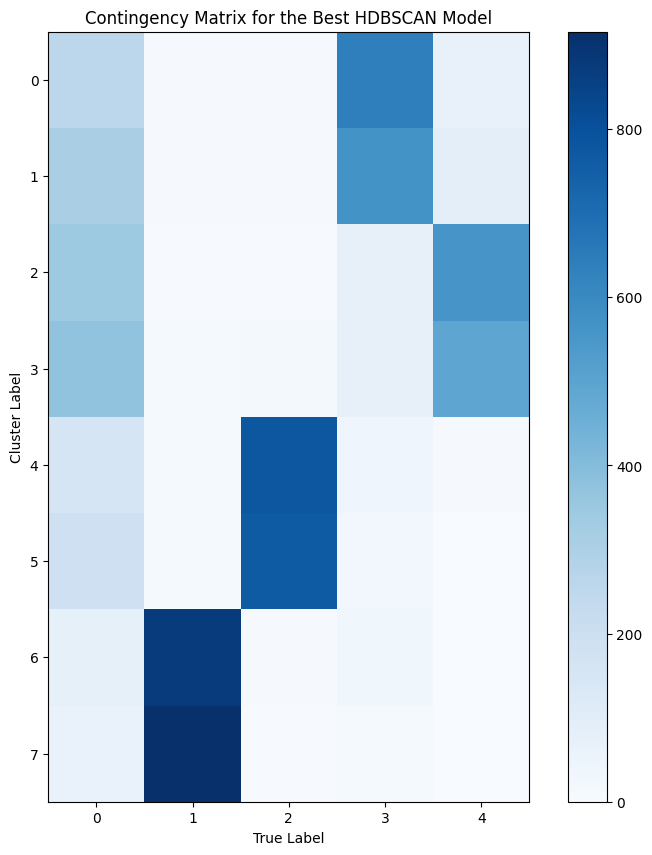

In [24]:
########## Question 16
best_eps = bestEpsHDBSCAN
best_min_samples = bestMinSamplesHDBSCAN
best_min_cluster = bestMinCluster

# Re-run the best HDBSCAN model
best_hdbs = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster, cluster_selection_epsilon=best_eps, min_samples=best_min_samples).fit_predict(wordCountUMAP)

# Compute the contingency matrix
contingency_mat = contingency_matrix(newsgroups_all.target, best_hdbs)

# Plot the contingency matrix
plt.figure(figsize=(10, 10))
plt.imshow(contingency_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Contingency Matrix for the Best HDBSCAN Model')
plt.xlabel('True Label')
plt.ylabel('Cluster Label')

# Add colorbar and show the plot
plt.colorbar()
plt.show()